In [1]:
%matplotlib inline

# notes: requires the file generated in tutorial manual_mesh_edition

In [2]:
# step 1. initialize

from math import *
import os.path
from tramway.helper import *
import time

## script main parameters ##

trajectory_file = 'glycine_receptor.trxyt'
tessellation_method = 'kmeans'
# average number of locations per cell
location_count = 500
# minimum number of locations per cell
min_location_count = 50

# in the same unit as in the trajectory file (here in micrometers)
localization_error = 0.03
diffusivity_smoothing = 1
potential_smoothing = 1
jeffreys_prior = False
# keep it low otherwise the inference will take days
max_iter = 100

curl_radius = 1

############################

rwa_file = os.path.splitext(trajectory_file)[0]+'.rwa'
mesh_label = '{}_{:d}_min_{:d}'.format(tessellation_method, location_count, min_location_count)
maps_label = 'sigma_{}_d_{}_v_{}_j_{:d}'.format(round(localization_error*1e3), diffusivity_smoothing, potential_smoothing, int(jeffreys_prior))
curl_label = 'curl_{}'.format(curl_radius)


In [3]:
# step 2. infer D and V (takes time!)

t0 = time.time()

infer(rwa_file, 'DV', max_iter=max_iter,
     sigma=localization_error,
     diffusivity_prior=diffusivity_smoothing,
     potential_prior=potential_smoothing,
     jeffreys_prior=jeffreys_prior,
     input_label=mesh_label, output_label=maps_label)

# take a break

print('elapsed time: {:d}s'.format(round(time.time()-t0)))


elapsed time: 6528s


/home/francois/github/TRamWAy/tramway/inference/dv.py:268: OptimizationWarning: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  warn('{}'.format(result.message), OptimizationWarning)


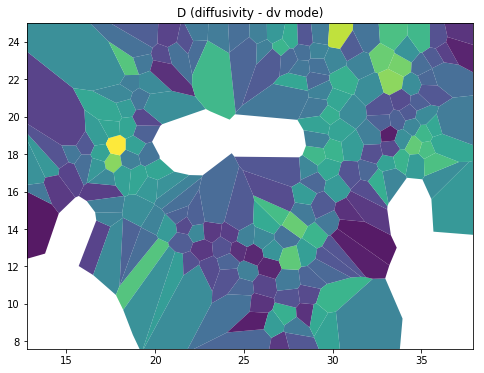

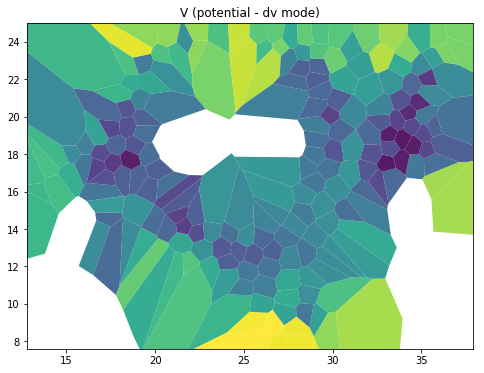

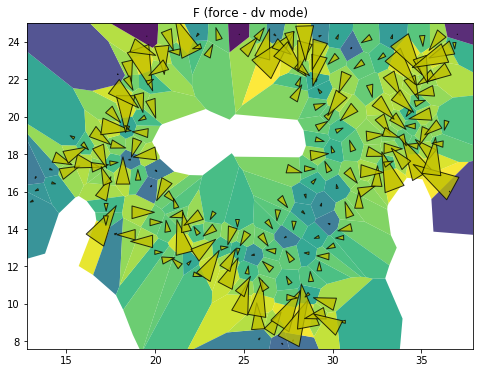

In [3]:
# step 3. plot the maps
map_plot(rwa_file, label=(mesh_label, maps_label), colorbar=None, transform={'force': np.log}, figsize=(8,6))

In [4]:
# step 4. calculate curls

# no helper yet; let us get our hands dirty

from tramway.core import find_artefacts
from tramway.tessellation import CellStats
from tramway.inference import Maps
from tramway.feature.curl import Curl
from copy import copy

# load the tessellation and inferred maps
analysis_tree = load_rwa(rwa_file)
cells, maps, tree_leaf = find_artefacts(analysis_tree, (CellStats, Maps), (mesh_label, maps_label), return_subtree=True)
# make new map with same meta-information as for the inferred maps
curl = copy(maps)
# calculate the curls
curl.maps = Curl(cells, maps).extract(curl_label, 'force', curl_radius)
# save
tree_leaf.add(curl, label=curl_label)
save_rwa(rwa_file, analysis_tree, force=True)

# bonus: "browse" the analysis tree
print(analysis_tree)
#<class 'pandas.core.frame.DataFrame'>                                  <- the trajectory data
#   'kmeans_500_min_50' <class 'tramway.tessellation.base.CellStats'>   <- the mesh and partition of the locations
#       'sigma_30_d_1_v_1_j_0' <class 'tramway.inference.base.Maps'>    <- the inferred maps
#           'curl_1' <class 'tramway.inference.base.Maps'>              <- the curl map


<class 'pandas.core.frame.DataFrame'>
	'kmeans_500_min_50' <class 'tramway.tessellation.base.CellStats'>
		'sigma_30_d_1_v_1_j_0' <class 'tramway.inference.base.Maps'>
			'curl_1' <class 'tramway.inference.base.Maps'>


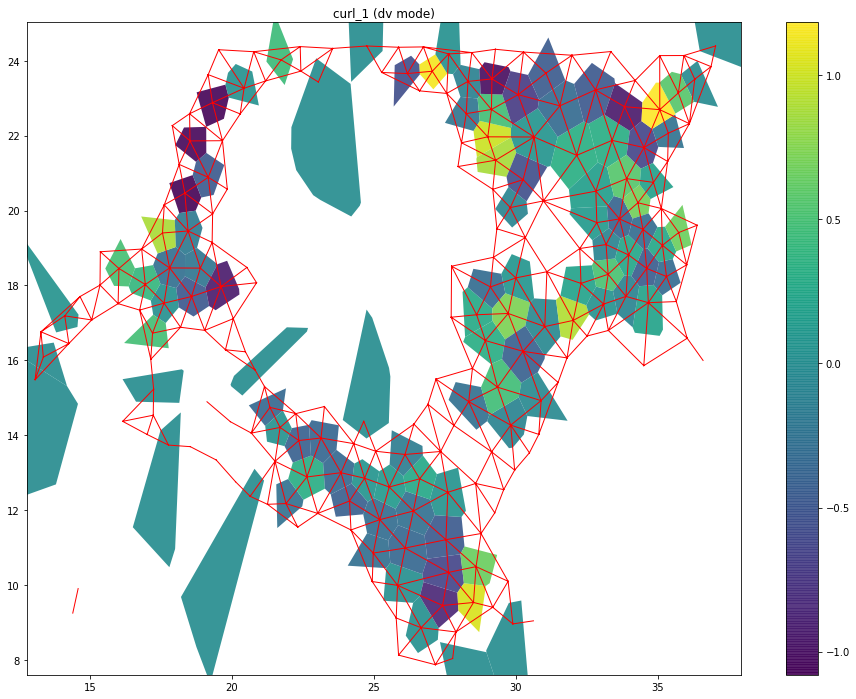

In [5]:
# step 5. plot the curl map
analysis_tree = load_rwa(rwa_file)
map_plot(analysis_tree, label=(mesh_label, maps_label, curl_label), show=False, figsize=(16,12))

# overlay the Delaunay graph to better understand the notes below
from tramway.plot.mesh import plot_delaunay
import matplotlib.pyplot as plt
plot_delaunay(analysis_tree[mesh_label].data, axes=plt.gca(), centroid_style=None)
plt.show()

# notes: many cells may be missing;
#        in most cases, there is no circular path around the missing cell, at the specified radius;
#        this can be appreciated with the Delaunay graph;
#        in the other cases, the circular-path-finding algorithm fails in finding a solution;
#        more importantly, the current algorithm finds solutions where there is not (!),
#        along the border of the Delaunay graph;
#        fortunately, the curl value at these unexpected locations is zero;
#        to be improved...

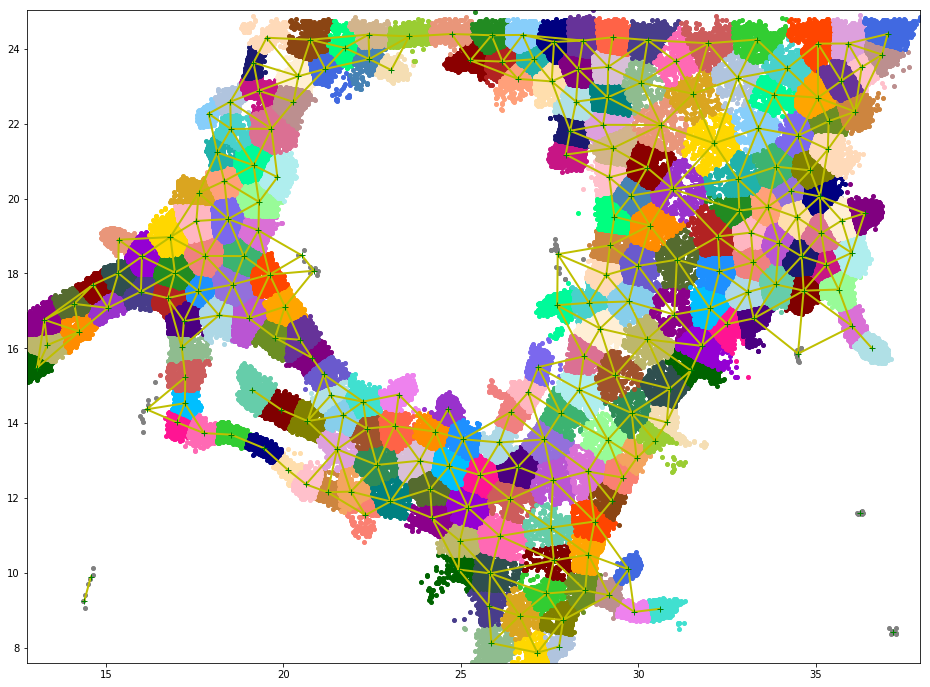

In [6]:
# compare the map above with the Delaunay graph again
cell_plot(rwa_file, label=mesh_label, voronoi=False, delaunay=dict(color='y', linewidth=2), figsize=(16,12))